In [1]:
import os
import nrrd
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from allensdk.api.queries.ontologies_api import OntologiesApi
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from allensdk.internal.core.lims_utilities import safe_system_path

%matplotlib inline

In [2]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
resolution = 100 #100 um for fMRI overlap
mcc = MouseConnectivityCache(manifest_file='../connectivity/mouse_connectivity_manifest.json',
                            resolution=resolution)

In [3]:
path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\T503_Connectivity_in_Alzheimer_Mice\Jennifer\DMN_paper'
cav_dir = os.path.join(path, 'downsampled_CAV', 'grid')
structure_dir = os.path.join(path, 'structure_masks')

In [4]:
from anatomy.anatomy_api import AnatomyApi # This is for getting data out of LIMS for unpublished image series. Will not work externally
aapi = AnatomyApi()
CAVis = aapi.get_image_series_by_workflow([471789262, 304950893])
len(CAVis)

135
62


197

In [5]:
from allensdk.api.queries.ontologies_api import OntologiesApi
oapi = OntologiesApi()
summary_structures = oapi.get_structures(structure_set_names="'Mouse Connectivity - Summary'")
summary_structure_ids = [item['id'] for item in summary_structures]
print(len(summary_structure_ids))
summary_structure_ids.remove(934) # ENTmv was removed from the ARA in October 2017
print(len(summary_structure_ids))

293
292


In [6]:
def get_structure_masks(structure_id, savepath=None):
        '''Get structure masks from Allenllen API
        
        Parameters
        ----------
        structure_id : int
            specifies structure
        savepath : string
            location to store masks for futre use
        
        '''
        structure_mask, _ = mcc.get_structure_mask(structure_id)
        if savepath:
            if not os.path.exists(savepath):
                os.mkdir(savepath)
            nrrd.write(os.path.join(savepath, 'structure_{0}_mask.nrrd'.format(structure_id)), structure_mask)
        else:
            return structure_mask

In [7]:
structure_dir_resolution = os.path.join(structure_dir, str(resolution))
for structure_id in summary_structure_ids:
    get_structure_masks(structure_id, structure_dir_resolution)

In [8]:
def make_fmri_masks(fmri_mask, savepath):
        '''Finds unique values in fmri volume and 
        generates a mask for each.
        '''
        if not os.path.exists(savepath):
            os.mkdir(savepath)
        unique_fmri_values = []
        for val in np.unique(fmri_mask):
            ival = int(val)
            unique_fmri_values.append(ival)
        
        for val in unique_fmri_values:
            val_mask = np.zeros(fmri_mask.shape)
            val_mask[np.where(fmri_mask == val)] = 1
            nrrd.write(os.path.join(savepath, 'fmri_{0}_mask.nrrd'.format(val)), val_mask)

In [9]:
dmn_mask, _ = nrrd.read(os.path.join(path, 'ica_all_05_icasso_iter_1000_comp_1_mask_z_1_allen_masked_sym_thresh_2.nrrd'))

In [10]:
mask_dir = os.path.join(path, 'fmri_masks')
make_fmri_masks(dmn_mask, mask_dir)
fmri0, _ = nrrd.read(os.path.join(mask_dir, 'fmri_0_mask.nrrd'))
fmri2, _ = nrrd.read(os.path.join(mask_dir, 'fmri_2_mask.nrrd'))

In [11]:
cavpath = os.path.join(cav_dir, str(CAVis[0]))
CAV, _ = nrrd.read(os.path.join(cavpath, 'cav_density_100.nrrd'))
np.unique(CAV)

array([-0.02918144, -0.02784236, -0.02689297, ...,  1.0047977 ,
        1.0075502 ,  1.0115197 ], dtype=float32)

In [13]:
CAVproj_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\T503_Connectivity_in_Alzheimer_Mice\Jennifer\DMN_paper\downsampled_CAV\segmentation_in_CAV_mask'
polysize = []
OL0 = []
OL2 = []
CAV_path = os.path.join(path, 'downsampled_CAV', 'grid')
for isid in CAVis:
    cavpath = os.path.join(cav_dir, str(isid))
    CAV, _ = nrrd.read(os.path.join(cavpath, 'cav_density_100.nrrd'))
    gridpath = os.path.join(aapi.get_storage_directory(isid), 'grid')
    proj, _ = nrrd.read(os.path.join(gridpath, 'projection_density_100.nrrd'))
    CAVmask = np.zeros(np.shape(CAV))
    CAVmask[np.where(CAV>0.001)] = 1
    CAVproj = proj * CAVmask
    projpath = os.path.join(CAVproj_path, str(isid))
    if not os.path.exists(projpath):
        os.mkdir(projpath)
    nrrd.write(os.path.join(projpath, 'projections_in_CAV_100.nrrd'), CAVproj)
    polysize.append(np.sum(CAVproj))
    OL0.append(np.sum(fmri0 * CAVproj))
    OL2.append(np.sum(fmri2 * CAVproj))

In [14]:
CAV_dat = pd.DataFrame({'image_series_id': CAVis, 'CAV_size': polysize, 'out_DMN': OL0, 'in_DMN': OL2})

In [15]:
CAV_dat.head()

,CAV_size,image_series_id,in_DMN,out_DMN
0,4.301542,475617622,4.286628,0.014914
1,0.372824,477435412,0.357691,0.015133
2,154.492207,475616128,149.967675,4.524531
3,12.928518,475733382,12.718109,0.210410
4,3.026836,475828414,3.016518,0.010318


In [16]:
CAV_dat['CAV_percent_DMN'] = CAV_dat[['in_DMN']].sum(axis = 1)/CAV_dat['CAV_size']*100

In [17]:
CAV_dat.head()

,CAV_size,image_series_id,in_DMN,out_DMN,CAV_percent_DMN
0,4.301542,475617622,4.286628,0.014914,99.653290
1,0.372824,477435412,0.357691,0.015133,95.940953
2,154.492207,475616128,149.967675,4.524531,97.071353
3,12.928518,475733382,12.718109,0.210410,98.372516
4,3.026836,475828414,3.016518,0.010318,99.659112


In [19]:
structure_tree = mcc.get_structure_tree()
ai_map = structure_tree.get_id_acronym_map()
ia_map = {value:key for key, value in ai_map.iteritems()}

In [20]:
CAVproj_path = os.path.join(path, 'downsampled_CAV', 'segmentation_in_CAV_mask')
isid = 525412369

cavpath = os.path.join(cav_dir, str(isid))
CAV, _ = nrrd.read(os.path.join(cavpath, 'cav_density_25.nrrd'))

In [21]:
CAV.shape

(528L, 320L, 456L)

In [22]:
gridpath = os.path.join(aapi.get_storage_directory(isid), 'grid')
proj, _ = nrrd.read(os.path.join(gridpath, 'projection_density_25.nrrd'))

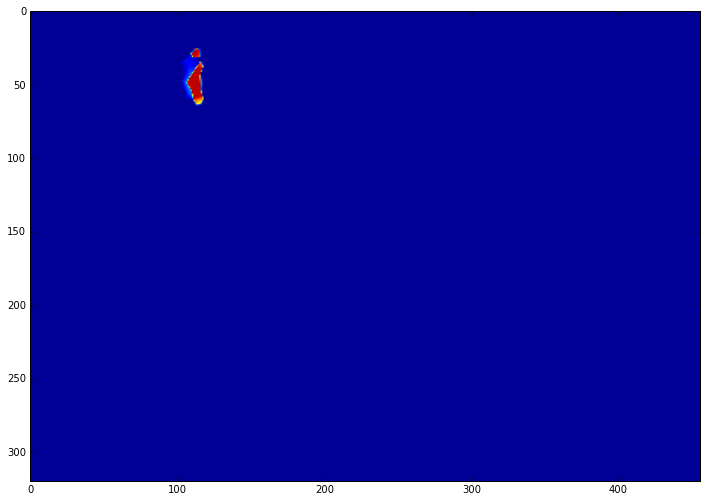

In [23]:
fig, ax=plt.subplots(1, 1, figsize = (12, 10))
plt.imshow(CAV[310])

In [24]:
np.unique(CAV)

array([-0.06486791, -0.06175356, -0.05829641, ...,  1.0632308 ,
        1.0642468 ,  1.0749624 ], dtype=float32)

In [25]:
CAVmask = np.zeros(np.shape(CAV))
CAVmask[np.where(CAV>0)] = 1

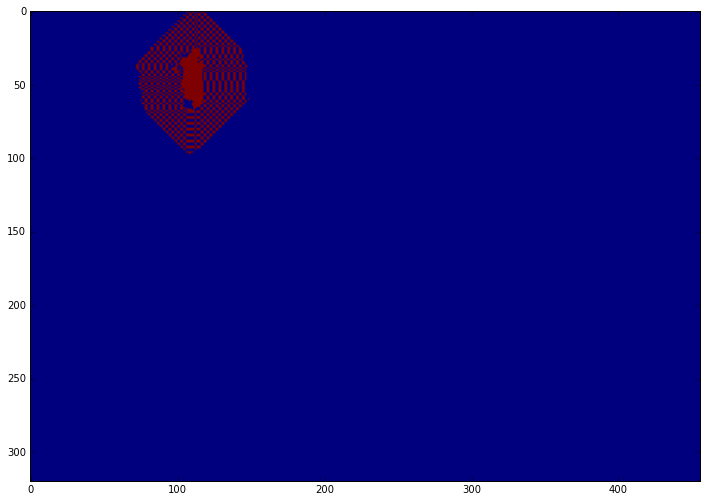

In [26]:
fig, ax=plt.subplots(1, 1, figsize=(12, 10))
plt.imshow(CAVmask[310])

In [27]:
CAVmask = np.zeros(np.shape(CAV))
CAVmask[np.where(CAV>.001)] = 1

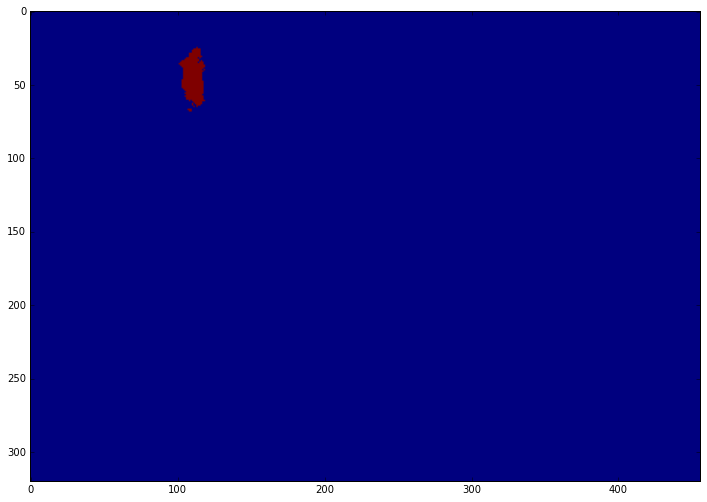

In [28]:
fig, ax=plt.subplots(1, 1, figsize = (12, 10))
plt.imshow(CAVmask[310],)

In [29]:
CAVproj_path = os.path.join(path, 'downsampled_CAV', 'segmentation_in_CAV_mask')
for isid in CAVis:
    cavpath = os.path.join(cav_dir, str(isid))
    CAV, _ = nrrd.read(os.path.join(cavpath, 'cav_density_25.nrrd'))
    gridpath = os.path.join(aapi.get_storage_directory(isid), 'grid')
    proj, _ = nrrd.read(os.path.join(gridpath, 'projection_density_25.nrrd'))
    CAVmask = np.zeros(np.shape(CAV))
    CAVmask[np.where(CAV>0.001)] = 1
    CAVproj = proj * CAVmask
    projpath = os.path.join(CAVproj_path, str(isid))
    if not os.path.exists(projpath):
        os.mkdir(projpath)
    nrrd.write(os.path.join(projpath, 'projections_in_CAV_25.nrrd'), CAVproj)

In [30]:
resolution = 25
mcc = MouseConnectivityCache(manifest_file='../connectivity/mouse_connectivity_manifest.json',
                            resolution=resolution)
structure_dir_resolution = os.path.join(structure_dir, str(resolution))
for structure_id in summary_structure_ids:
    get_structure_masks(structure_id, structure_dir_resolution)

2020-03-07 19:02:43,381 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_184.nrrd
2020-03-07 19:02:44,453 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_985.nrrd
2020-03-07 19:02:45,638 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_993.nrrd
2020-03-07 19:02:46,908 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_353.nrrd
2020-03-07 19:02

2020-03-07 19:03:21,582 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_119.nrrd
2020-03-07 19:03:22,630 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_894.nrrd
2020-03-07 19:03:23,786 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_879.nrrd
2020-03-07 19:03:25,019 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_886.nrrd
2020-03-07 19:03

2020-03-07 19:04:00,088 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_966.nrrd
2020-03-07 19:04:01,191 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_131.nrrd
2020-03-07 19:04:02,325 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_295.nrrd
2020-03-07 19:04:03,375 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_319.nrrd
2020-03-07 19:04

2020-03-07 19:04:37,078 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_414.nrrd
2020-03-07 19:04:38,079 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_422.nrrd
2020-03-07 19:04:39,075 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_609.nrrd
2020-03-07 19:04:40,275 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_1044.nrrd
2020-03-07 19:0

2020-03-07 19:05:13,280 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_390.nrrd
2020-03-07 19:05:14,315 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_332.nrrd
2020-03-07 19:05:15,355 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_38.nrrd
2020-03-07 19:05:16,371 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_30.nrrd
2020-03-07 19:05:1

2020-03-07 19:05:48,990 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_226.nrrd
2020-03-07 19:05:50,059 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_356.nrrd
2020-03-07 19:05:51,094 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_364.nrrd
2020-03-07 19:05:52,148 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_173.nrrd
2020-03-07 19:05

2020-03-07 19:06:24,970 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_1052.nrrd
2020-03-07 19:06:26,022 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_12.nrrd
2020-03-07 19:06:27,055 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_100.nrrd
2020-03-07 19:06:28,078 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_197.nrrd
2020-03-07 19:06

2020-03-07 19:07:01,177 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_651.nrrd
2020-03-07 19:07:02,263 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_429.nrrd
2020-03-07 19:07:03,414 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_437.nrrd
2020-03-07 19:07:04,437 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_445.nrrd
2020-03-07 19:07

2020-03-07 19:07:37,381 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_230.nrrd
2020-03-07 19:07:38,414 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_222.nrrd
2020-03-07 19:07:39,477 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_912.nrrd
2020-03-07 19:07:40,614 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_920.nrrd
2020-03-07 19:07

In [31]:
CAV_dat['primary_target_polygon'] = ""
CAV_dat['secondary_target_polygon'] = ""
CAV_dat['primary_target_segmentation'] = ""
CAV_dat['secondary_target_segmentation'] = ""
# Get primary and secondary injection structures for CAV data. 
# Consider updating to integrate projection segmentation inside CAV polygon for more precise definition of target
# Consider doing this at 25 um
for isid in os.listdir(cav_dir):
    try:
        CAV, _ = nrrd.read(os.path.join(cav_dir, isid, 'cav_density_25.nrrd'))
        CAVseg, _ = nrrd.read(os.path.join(CAVproj_path, isid, 'projections_in_CAV_25.nrrd'))
        isid = int(isid)
        maxOL = 0
        maxprojOL = 0
        OL = 0
        projOL = 0
        secondary = 997
        projsecondary = 997
        primary = 997
        projprimary = 997
        for mask in os.listdir(os.path.join(structure_dir, '25')):
            structure = mask[10:-10]
            if not any(structure in parent_structures for parent_structures in ['997', '688', '315', '8', '1080', '1009', '998']): 
                #parent structures: root, cortex, isocortex, basic, hippocampus, fiber tracts 
                strmask, _ = nrrd.read(os.path.join(structure_dir, '25', mask))

                OL = np.sum(strmask * CAV)
                if OL > maxOL:
                    maxOL = OL
                    secondary = primary
                    primary = mask[10:-10]
                projOL = np.sum(strmask * CAVseg)
                if projOL > maxprojOL:
                    maxprojOL = projOL
                    projsecondary = projprimary
                    projprimary = mask[10:-10]
        CAV_dat.loc[CAV_dat['image_series_id'] == isid, 'primary_target_polygon'] = int(primary)
        CAV_dat.loc[CAV_dat['image_series_id'] == isid, 'secondary_target_polygon'] = int(secondary)
        CAV_dat.loc[CAV_dat['image_series_id'] == isid, 'primary_target_segmentation'] = int(projprimary)
        CAV_dat.loc[CAV_dat['image_series_id'] == isid, 'secondary_target_segmentation'] = int(projsecondary)
    except:
        print(isid)
        continue

595458351
521260281
551737360
475734796
601480907
475614691
526515319
579204767
596575967


In [32]:
CAV_dat['primary_target_acronym_polygon'] = [ia_map[primary] for primary in CAV_dat['primary_target_polygon']]
CAV_dat['secondary_target_acronym_polygon'] = [ia_map[secondary] for secondary in CAV_dat['secondary_target_polygon']]
CAV_dat['primary_target_acronym_segmentation'] = [ia_map[primary] for primary in CAV_dat['primary_target_segmentation']]
CAV_dat['secondary_target_acronym_segmentation'] = [ia_map[secondary] for secondary in CAV_dat['secondary_target_segmentation']]

In [34]:
CAV_dat.tail()

,CAV_size,image_series_id,in_DMN,out_DMN,CAV_percent_DMN,primary_target_polygon,secondary_target_polygon,primary_target_segmentation,secondary_target_segmentation,primary_target_acronym_polygon,secondary_target_acronym_polygon,primary_target_acronym_segmentation,secondary_target_acronym_segmentation
192,4.892134,585022673,0.000000,4.892134,0.000000,672,329,672,329,CP,SSp-bfd,CP,SSp-bfd
193,0.018269,585931968,0.000000,0.018269,0.000000,797,381,374,726,ZI,SNr,SNc,DG
194,3.443631,585761377,0.094521,3.349110,2.744798,672,985,672,985,CP,MOp,CP,MOp
195,70.954710,591168591,67.062205,3.892505,94.514099,723,151,746,723,ORBl,AOB,ORBvl,ORBl
196,0.638011,589398486,0.000000,0.638011,0.000000,931,612,931,997,PG,NLL,PG,root


In [36]:
CAV_dat[CAV_dat['image_series_id'].isin([664716091, 666090944, 868641659])]

,CAV_size,image_series_id,in_DMN,out_DMN,CAV_percent_DMN,primary_target_polygon,secondary_target_polygon,primary_target_segmentation,secondary_target_segmentation,primary_target_acronym_polygon,secondary_target_acronym_polygon,primary_target_acronym_segmentation,secondary_target_acronym_segmentation
100,2.912948,664716091,0.0,2.912948,0.0,879,385,879,385,RSPd,VISp,RSPd,VISp
101,4.548829,666090944,0.0,4.548829,0.0,425,385,425,385,VISpl,VISp,VISpl,VISp
131,0.380682,868641659,0.0,0.380682,0.0,385,997,385,997,VISp,root,VISp,root


In [35]:
CAV_dat[CAV_dat['primary_target_acronym_polygon'] != CAV_dat['primary_target_acronym_segmentation']][[
    'image_series_id', 'primary_target_acronym_polygon', 'primary_target_acronym_segmentation',
        'secondary_target_acronym_polygon', 'secondary_target_acronym_segmentation']]

,image_series_id,primary_target_acronym_polygon,primary_target_acronym_segmentation,secondary_target_acronym_polygon,secondary_target_acronym_segmentation
0,475617622,RSPd,RSPagl,root,RSPd
2,475616128,PL,ILA,ORBm,ACAd
7,475830603,ACAv,MOs,LSc,ACAv
17,521954271,TEa,ECT,AUDd,TEa
25,527393013,ECT,CA1,CA1,AUDp
26,527711024,ACAd,PL,ACAv,ACAv
28,524267323,AId,AIv,CLA,AId
32,521255975,ACAd,ACAv,ACAv,root
36,528511254,PL,ORBvl,ORBm,ACAd
43,523177830,AId,AIv,MOs,AId


In [37]:
len(CAV_dat)

197

In [38]:
CAV_dat.to_csv(os.path.join(path, 'CAV_primary_injection_structures_25.csv'))

In [39]:
path

'\\\\allen\\programs\\celltypes\\workgroups\\mousecelltypes\\T503_Connectivity_in_Alzheimer_Mice\\Jennifer\\DMN_paper'